# HW2P2: Face Classification and Verification


This is the second homework in 11785: Introduction to Deep Learning consisting of two parts:
*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities.
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities.

For this HW, you only have to write code to implement your model architecture. Everything else has been provided for you, on the pretext that most of your time will be used up in developing the suitable model architecture for achieving satisfactory performance.

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# TODOs
As you go, please read the code and keep an eye out for TODOs.

**Structure of this notebook**:

1. **Libraries** - just run it
2. **Kaggle** - copy the code from HW1P2 and add a correct API key
3. **Configs** - specify your configs
4. **Dataset**
  - **Datasets and Dataloaders** - it's already implemented, just specify your preferred augmentations/transformations
  - **EDA and Viz** - just run it to check if your augmentations/transformations worked
5. **Model Architecture** - implement and define your preferred model architecture
6. **Loss, Optimizer, and Scheduler** - define your loss, optimizer, and a scheduler
7. **Training and Validation Functions** - includes functions for both classification and verification tasks
  - **Classification Task** - just run it
  - **Verification Task** - just run it
8. **Wandb** - add a correct API key
9. **Experiments** - make changes if needed; it will show you train/val/test accuracy for both classification and verification. **Important**: make sure you save your best model checkpoints because models in this HW take a long time to get trained
10. **Testing and Kaggle Submission** - just run it
11. **Model Finetuning** - this part might help you get a higher score on the verification part
  - **Model Implementations (CenterLoss, ArcFace, or SphereFace)** - please refer to the additional notebook and just copy the model from there
  - **Model Definition (finetuning)** - you may reuse the code from the main part
  - **Loss, Optimizer, and Scheduler Definition (finetuning)** - you may reuse the code from the main part
  - **Training Function (finetuning)** - you may reuse the code from the main part
  - **Wandb (finetuning)** - you may reuse the code from the main part
  - **Experiments (finetuning)** - you may reuse the code from the main part

Good luck!

# Libraries

In [ ]:
!nvidia-smi # Run this to see what GPU you have

Fri Mar  8 15:51:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#NOTE: RESTART THE RUN TIME AFTER RUNNING THE THE CELL BELOW

In [ ]:
# Install the necessary packages. Very important: Please restart your session in Colab/Local Machine
# You can restart your session in colab by going to Runtime and then clicking restart session
!pip install wandb --quiet
!pip install torch==1.12.1 torchvision==0.13.1 torchaudio==0.12.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.3/776.3 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 84.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.1.0+cu121
    Uninstalling torch-2.1.0+cu121:
      Successfully uninstalled torch-2.1.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.0+cu121
    Uninstalling torchvision-0.16.0+cu121:
      Successfully uninstalled torchvision-0.16.0+cu121
  Attempting uninstall: torchaudio
    Found existing installation: torch

In [ ]:
# Import the important packages for this Homework. Feel free to add anything here you need.
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision # This library is used for image-based operations (Augmentations)
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [ ]:
# from google.colab import drive # Link to your drive if you are not using Colab with GCP
# drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it here

# Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"llynoirx","key":"b2ce5eadd838f8ca8066ecc979807b17"}')

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73248 sha256=2a5ef4394ccae1e741213ad96b839831163d1d3cac96805af6c9265d607e74ed
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
# Reminder: Make sure you have connected your kaggle API before running this block
!mkdir '/content/data'

!kaggle competitions download -c 11785-hw2p2-face-recognition
!unzip -qo '11785-hw2p2-face-recognition.zip' -d '/content/data'

!kaggle competitions download -c 11785-hw2p2-face-verification
!unzip -qo '11785-hw2p2-face-verification.zip' -d '/content/data'

 99% 1.70G/1.71G [00:17<00:00, 79.1MB/s]
100% 1.71G/1.71G [00:17<00:00, 104MB/s] 
 42% 7.00M/16.8M [00:00<00:00, 72.5MB/s]
100% 16.8M/16.8M [00:00<00:00, 115MB/s] 


# Configs

In [ ]:
config = {
    'architecture': "ResNet50-3x3",
    'batch_size': 256, # Increase this if your GPU can handle it
    'lr': 0.1,
    'epochs': 100, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Dataset

## Datasets and Dataloaders


In [ ]:
# --------------------------------------------------- #

# Data paths

DATA_DIR    = "/content/data/11-785-s24-hw2p2-classification"
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# --------------------------------------------------- #

# Transformations/augmentations of the Train dataset

"""
Refer https://pytorch.org/vision/stable/transforms.html
Implementing the right train transforms/augmentation methods is key to improving performance.
Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
But there are some transforms which are performed after ToTensor() : e.g - Normalization
#Normalization Tip - Do not blindly use normalization that is not suitable for this dataset
"""

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.ToTensor()
    ]) # TODO: Specify transformations/augmentations performed on the train dataset

# --------------------------------------------------- #

# Transformations/augmentations of the Val dataset

"""
You should NOT have data augmentation on the validation set. Why?
"""

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
    ]) # TODO: Specify transformations performed on the val dataset

# --------------------------------------------------- #

# Initializing the train and val datasets

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform = train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform = valid_transforms)

# --------------------------------------------------- #

# Initializing the train and val dataloaders

train_loader = torch.utils.data.DataLoader(dataset       = train_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = True,
                                           # num_workers = 4, # Uncomment this line if you want to increase your num workers
                                           pin_memory    = True)

valid_loader = torch.utils.data.DataLoader(dataset       = valid_dataset,
                                           batch_size    = config['batch_size'],
                                           shuffle        = False,
                                           # num_workers = 2 # Uncomment this line if you want to increase your num workers
                                           )

In [ ]:
# --------------------------------------------------- #

# Test dataset class

"""
You can do this with ImageFolder as well, but it requires some tweaking
"""

class TestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

# --------------------------------------------------- #

# Initializing the test dataset

"""
Why are we using val_transforms for Test Data?
"""

test_dataset = TestDataset(TEST_DIR, transforms = valid_transforms)

# --------------------------------------------------- #

# Initializing the test dataloader

test_loader = torch.utils.data.DataLoader(dataset    = test_dataset,
                                          batch_size = config['batch_size'],
                                          shuffle     = False,
                                          drop_last  = False,
                                          # num_workers = 2 # Uncomment this line if you want to increase your num workers
                                          )

## EDA and Viz

In [ ]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  256
Train batches        :  547
Val batches          :  137


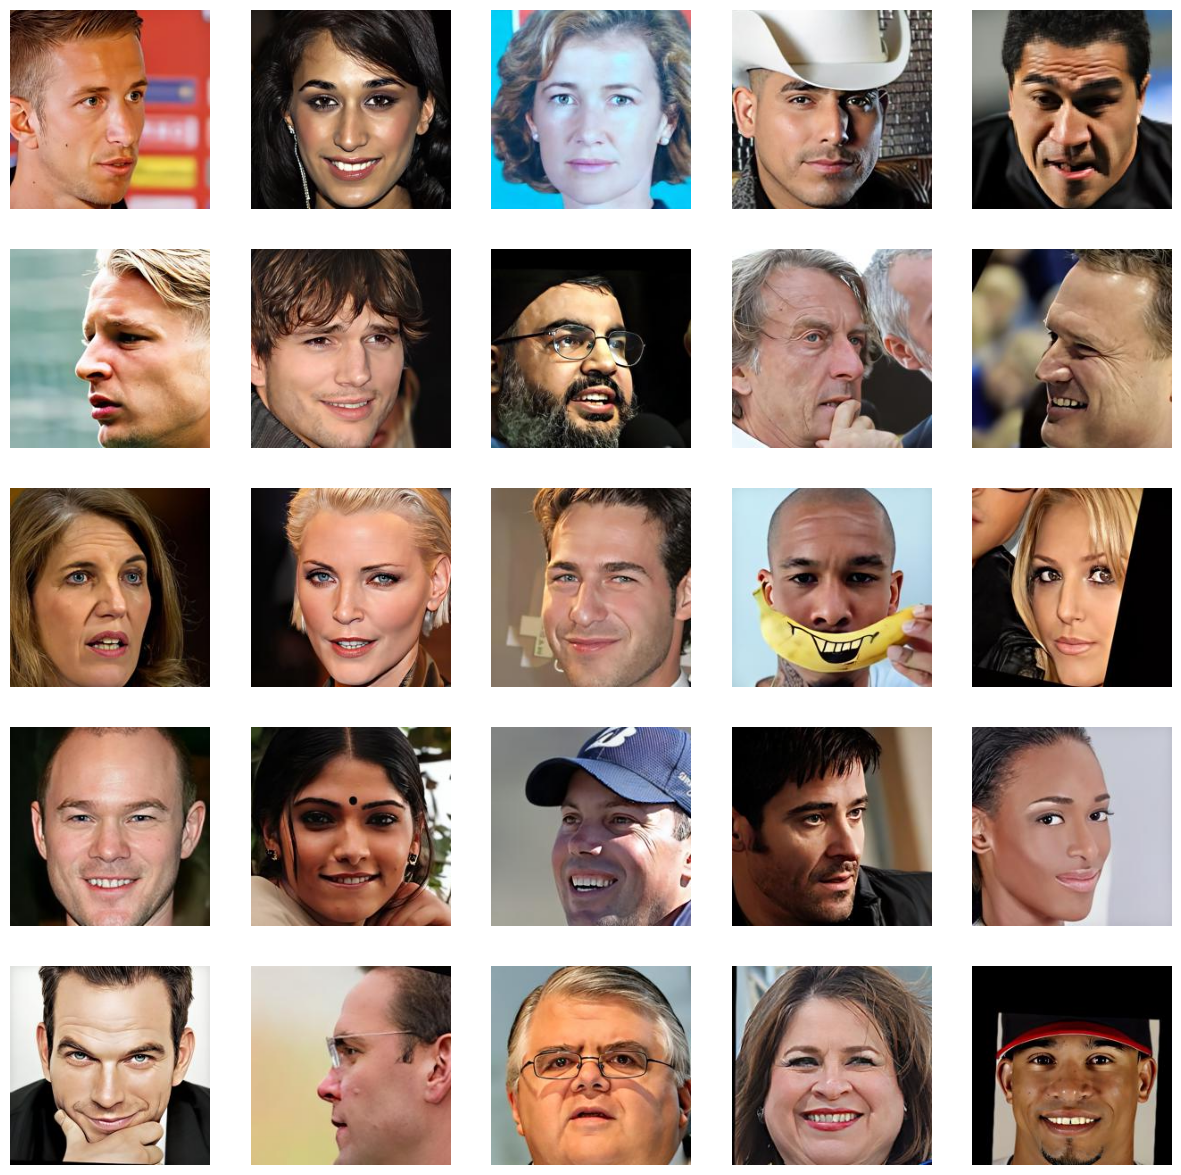

In [ ]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Model Architecture

FAQ:

**What's a very low early deadline architecture (mandatory early submission)**?

- The very low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 18M.
- The first convolutional layer has 64 channels, kernel size 7, and stride 4. The next four have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2. Documentation to make convolutional layers: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
- Think about strided convolutions from the lecture, as convolutions with stride = 1 and downsampling. For strided convolution, what padding do you need for preserving the spatial resolution? (Hint => padding = kernel_size // 2) - Think why?
- Each convolutional layer is accompanied by a Batchnorm and ReLU layer.
- Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d. Documentation for AdaptiveAvgPool2d: https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
- Then, remove (Flatten?) these trivial 1x1 dimensions away.
Look through https://pytorch.org/docs/stable/nn.html


**Why does a very simple network have 4 convolutions**?

Input images are 224x224. Note that each of these convolutions downsample. Downsampling 2x effectively doubles the receptive field, increasing the spatial region each pixel extracts features from. Downsampling 32x is standard for most image models.

**Why does a very simple network have high channel sizes**?

Every time you downsample 2x, you do 4x less computation (at same channel size). To maintain the same level of computation, you 2x increase # of channels, which increases computation by 4x. So, balances out to same computation. Another intuition is - as you downsample, you lose spatial information. We want to preserve some of it in the channel dimension.

**What is return_feats?**

It essentially returns the second-to-last-layer features of a given image. It's a "feature encoding" of the input image, and you can use it for the verification task. You would use the outputs of the final classification layer for the classification task. You might also find that the classification outputs are sometimes better for verification too - try both.

ResNet Paper: https://arxiv.org/abs/1512.03385

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        # (1st) 3x3
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # (2nd) 3x3
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_classes=7001):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2_x = self.residual_layer(in_channels=64, out_channels=64, stride=1, num_blocks=4)
        self.conv3_x = self.residual_layer(in_channels=64, out_channels=128, stride=2, num_blocks=4)
        self.conv4_x = self.residual_layer(in_channels=128, out_channels=256, stride=2, num_blocks=4)
        self.conv5_x = self.residual_layer(in_channels=256, out_channels=512, stride=2, num_blocks=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.cls_layer = nn.Linear(512, num_classes)

    def residual_layer(self, in_channels, out_channels, stride, num_blocks):
        stages = [ResBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            stages.append(ResBlock(out_channels, out_channels, 1))
        return nn.Sequential(*stages)

    def forward(self, x, return_feats=False):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.conv2_x(out)
        out = self.conv3_x(out)
        out = self.conv4_x(out)
        out = self.conv5_x(out)

        out = self.avgpool(out)
        out = torch.flatten(out, 1)

        if return_feats:
          return out

        out = self.cls_layer(out)
        return out

# Initialize your model
model = ResNet(num_classes=7001).to(DEVICE)
summary(model, (3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
         ResBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Loss, Optimizer, and Scheduler Definition

In [ ]:
# --------------------------------------------------- #

# Defining Loss function
criterion = nn.CrossEntropyLoss() # TODO: would label smoothing be beneficial here?

# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config['lr'],
                            momentum=0.9,
                            weight_decay=1e-4) # TODO: Feel free to pick a different optimizer

# --------------------------------------------------- #

# Defining Scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=config['epochs'], eta_min=0.001)

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

# Training and Validation Functions

## Classification Task

In [ ]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

    #load state dict

In [ ]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

## Verification Task

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [ ]:
# This obtains the list of known identities from the known folder
known_regex = "/content/data/11-785-s24-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "/content/data/11-785-s24-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 11567.93it/s]


In [ ]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    # pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    threshold = np.median(max_similarity_values)
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])

    if mode == 'val':
      true_ids = pd.read_csv('/content/data/11-785-s24-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = 100 * accuracy_score(pred_id_strings, true_ids)
      #print("Verification Accuracy = {}".format(accuracy))
      return accuracy, pred_id_strings

    elif mode == 'test':
      return pred_id_strings


In [ ]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [ ]:
wandb.login(key="f3b2c9738d42f0a8cccb942fd7050e6854a48f84") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Currently logged in as: llynoirx (no-loss). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Create your wandb run
run = wandb.init(
    name = "kh-"+config['architecture'], ## Wandb creates random run names if you skip this field
    # reinit = True, ### Allows reinitalizing runs when you re-run this cell
    id = "wb3ez2v3", ###Insert specific run id here if you want to resume a previous run
    resume = "must", ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

In [ ]:
### Save your model architecture as a string with str(model)
model_arch  = str(model)

### Save it in a txt file
arch_file   = open(config['architecture']+"_modelarch.txt", "w")
file_write  = arch_file.write(model_arch)
arch_file.close()

### log it in your wandb run with wandb.save()
wandb.save(config['architecture']+"model-arch.txt")

[]

# Experiments

In [ ]:
best_class_acc      = 0.0
best_ver_acc        = 0.0

for epoch in range(config['epochs']):

    # print("\nEpoch {}/{}".format(epoch+1, config['epochs']))

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc (Classification) {:.04f}%\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['epochs'], train_acc, train_loss, curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)
    print("Val Acc (Classification) {:.04f}%\t Val Loss (Classification) {:.04f}".format(val_acc, val_loss))

    ver_acc, pred_id_strings = eval_verification(unknown_dev_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='val')

    print("Val Acc (Verification) {:.04f}%\t ".format(ver_acc))

    wandb.log({"train_classification_acc": train_acc,
               "train_classification_loss":train_loss,
               "val_classification_acc": val_acc,
               "val_classification_loss": val_loss,
               "val_verification_acc": ver_acc,
               "learning_rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop,
    # How will you step your scheduler ?
    scheduler.step()

    if val_acc >= best_class_acc:
        best_valid_acc = val_acc
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_acc': val_acc,
                    'epoch': epoch}, './checkpoint_classification.pth')
        wandb.save('checkpoint_verification.pth')
        print("Saved best classification model")

    if ver_acc >= best_ver_acc:
      best_ver_acc = ver_acc
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': ver_acc,
                  'epoch': epoch}, './checkpoint_verification.pth')
      wandb.save('checkpoint_verification.pth')
      print("Saved verification model")

### Finish your wandb run
# run.finish()


Epoch 1/100: 
Train Acc (Classification) 0.0221%	 Train Loss (Classification) 8.8112	 Learning Rate 0.1000


Val Acc (Classification) 0.0371%	 Val Loss (Classification) 8.6449


Val Acc (Verification) 4.7222%	 
Saved best classification model
Saved verification model



Epoch 2/100: 
Train Acc (Classification) 0.0993%	 Train Loss (Classification) 8.2711	 Learning Rate 0.0999


Val Acc (Classification) 0.2766%	 Val Loss (Classification) 7.8194


Val Acc (Verification) 6.9444%	 
Saved best classification model
Saved verification model



Epoch 3/100: 
Train Acc (Classification) 1.2154%	 Train Loss (Classification) 7.0123	 Learning Rate 0.0996


Val Acc (Classification) 1.5596%	 Val Loss (Classification) 6.9678


Val Acc (Verification) 10.2778%	 
Saved best classification model
Saved verification model



Epoch 4/100: 
Train Acc (Classification) 6.2557%	 Train Loss (Classification) 5.7104	 Learning Rate 0.0991


Val Acc (Classification) 7.1966%	 Val Loss (Classification) 5.6105


Val Acc (Verification) 12.5000%	 
Saved best classification model
Saved verification model



Epoch 5/100: 
Train Acc (Classification) 16.3384%	 Train Loss (Classification) 4.5724	 Learning Rate 0.0984


Val Acc (Classification) 14.2250%	 Val Loss (Classification) 4.9562


Val Acc (Verification) 17.5000%	 
Saved best classification model
Saved verification model



Epoch 6/100: 
Train Acc (Classification) 29.5261%	 Train Loss (Classification) 3.5943	 Learning Rate 0.0976


Val Acc (Classification) 19.4315%	 Val Loss (Classification) 4.5147


Val Acc (Verification) 21.3889%	 
Saved best classification model
Saved verification model



Epoch 7/100: 
Train Acc (Classification) 42.5060%	 Train Loss (Classification) 2.8115	 Learning Rate 0.0965


Val Acc (Classification) 30.4488%	 Val Loss (Classification) 3.7146


Val Acc (Verification) 21.9444%	 
Saved best classification model
Saved verification model



Epoch 8/100: 
Train Acc (Classification) 53.6999%	 Train Loss (Classification) 2.2211	 Learning Rate 0.0953


Val Acc (Classification) 42.2930%	 Val Loss (Classification) 2.9796


Val Acc (Verification) 23.6111%	 
Saved best classification model
Saved verification model



Epoch 9/100: 
Train Acc (Classification) 62.1951%	 Train Loss (Classification) 1.7827	 Learning Rate 0.0939


Val Acc (Classification) 46.3390%	 Val Loss (Classification) 2.8287


Val Acc (Verification) 27.2222%	 
Saved best classification model
Saved verification model



Epoch 10/100: 
Train Acc (Classification) 69.2577%	 Train Loss (Classification) 1.4432	 Learning Rate 0.0923


Val Acc (Classification) 47.4937%	 Val Loss (Classification) 2.7140


Val Acc (Verification) 25.8333%	 
Saved best classification model



Epoch 11/100: 
Train Acc (Classification) 74.6794%	 Train Loss (Classification) 1.1748	 Learning Rate 0.0905


Val Acc (Classification) 51.6851%	 Val Loss (Classification) 2.5484


Val Acc (Verification) 28.0556%	 
Saved best classification model
Saved verification model



Epoch 12/100: 
Train Acc (Classification) 79.3890%	 Train Loss (Classification) 0.9567	 Learning Rate 0.0886


Val Acc (Classification) 56.8260%	 Val Loss (Classification) 2.3165


Val Acc (Verification) 28.0556%	 
Saved best classification model
Saved verification model



Epoch 13/100: 
Train Acc (Classification) 83.2717%	 Train Loss (Classification) 0.7774	 Learning Rate 0.0866


Val Acc (Classification) 58.5880%	 Val Loss (Classification) 2.2627


Val Acc (Verification) 33.0556%	 
Saved best classification model
Saved verification model



Epoch 14/100: 
Train Acc (Classification) 86.6416%	 Train Loss (Classification) 0.6297	 Learning Rate 0.0844


Val Acc (Classification) 61.7359%	 Val Loss (Classification) 2.1256


Val Acc (Verification) 33.6111%	 
Saved best classification model
Saved verification model



Epoch 15/100: 
Train Acc (Classification) 89.4296%	 Train Loss (Classification) 0.5070	 Learning Rate 0.0821


Val Acc (Classification) 61.0002%	 Val Loss (Classification) 2.1585


Val Acc (Verification) 33.6111%	 
Saved best classification model
Saved verification model



Epoch 16/100: 
Train Acc (Classification) 91.6719%	 Train Loss (Classification) 0.4070	 Learning Rate 0.0796


Val Acc (Classification) 63.5350%	 Val Loss (Classification) 2.1051


Val Acc (Verification) 35.5556%	 
Saved best classification model
Saved verification model



Epoch 17/100: 
Train Acc (Classification) 93.8028%	 Train Loss (Classification) 0.3165	 Learning Rate 0.0770


Val Acc (Classification) 61.4194%	 Val Loss (Classification) 2.2454


Val Acc (Verification) 32.5000%	 
Saved best classification model



Epoch 18/100: 
Train Acc (Classification) 95.4618%	 Train Loss (Classification) 0.2447	 Learning Rate 0.0743


Val Acc (Classification) 64.9578%	 Val Loss (Classification) 2.0626


Val Acc (Verification) 33.3333%	 
Saved best classification model



Epoch 19/100: 
Train Acc (Classification) 97.0850%	 Train Loss (Classification) 0.1754	 Learning Rate 0.0716


Val Acc (Classification) 66.7855%	 Val Loss (Classification) 2.0454


Val Acc (Verification) 35.5556%	 
Saved best classification model
Saved verification model



Epoch 20/100: 
Train Acc (Classification) 98.2647%	 Train Loss (Classification) 0.1212	 Learning Rate 0.0687


Val Acc (Classification) 69.1121%	 Val Loss (Classification) 1.8964


Val Acc (Verification) 34.4444%	 
Saved best classification model



Epoch 21/100: 
Train Acc (Classification) 99.0316%	 Train Loss (Classification) 0.0818	 Learning Rate 0.0658


Val Acc (Classification) 70.5891%	 Val Loss (Classification) 1.8490


Val Acc (Verification) 36.9444%	 
Saved best classification model
Saved verification model



Epoch 22/100: 
Train Acc (Classification) 99.5237%	 Train Loss (Classification) 0.0550	 Learning Rate 0.0628


Val Acc (Classification) 73.2436%	 Val Loss (Classification) 1.7162


Val Acc (Verification) 36.1111%	 
Saved best classification model



Epoch 23/100: 
Train Acc (Classification) 99.7536%	 Train Loss (Classification) 0.0396	 Learning Rate 0.0598


Val Acc (Classification) 73.3719%	 Val Loss (Classification) 1.7071


Val Acc (Verification) 36.6667%	 
Saved best classification model



Epoch 24/100: 
Train Acc (Classification) 99.9015%	 Train Loss (Classification) 0.0308	 Learning Rate 0.0567


Val Acc (Classification) 74.7377%	 Val Loss (Classification) 1.6298


Val Acc (Verification) 36.1111%	 
Saved best classification model



Epoch 25/100: 
Train Acc (Classification) 99.9507%	 Train Loss (Classification) 0.0266	 Learning Rate 0.0536


Val Acc (Classification) 75.4391%	 Val Loss (Classification) 1.5872


Val Acc (Verification) 35.8333%	 
Saved best classification model



Epoch 26/100: 
Train Acc (Classification) 99.9786%	 Train Loss (Classification) 0.0242	 Learning Rate 0.0505


Val Acc (Classification) 75.7584%	 Val Loss (Classification) 1.5576


Val Acc (Verification) 37.7778%	 
Saved best classification model
Saved verification model



Epoch 27/100: 
Train Acc (Classification) 99.9857%	 Train Loss (Classification) 0.0237	 Learning Rate 0.0474


Val Acc (Classification) 75.8497%	 Val Loss (Classification) 1.5607


Val Acc (Verification) 36.9444%	 
Saved best classification model



Epoch 28/100: 
Train Acc (Classification) 99.9907%	 Train Loss (Classification) 0.0237	 Learning Rate 0.0443


Val Acc (Classification) 76.2118%	 Val Loss (Classification) 1.5283


Val Acc (Verification) 37.5000%	 
Saved best classification model



Epoch 29/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0237	 Learning Rate 0.0412


Val Acc (Classification) 76.1776%	 Val Loss (Classification) 1.5268


Val Acc (Verification) 37.5000%	 
Saved best classification model



Epoch 30/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0238	 Learning Rate 0.0382


Val Acc (Classification) 76.5311%	 Val Loss (Classification) 1.5081


Val Acc (Verification) 36.9444%	 
Saved best classification model



Epoch 31/100: 
Train Acc (Classification) 99.9907%	 Train Loss (Classification) 0.0240	 Learning Rate 0.0352


Val Acc (Classification) 76.5910%	 Val Loss (Classification) 1.5024


Val Acc (Verification) 38.6111%	 
Saved best classification model
Saved verification model



Epoch 32/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0238	 Learning Rate 0.0323


Val Acc (Classification) 76.7279%	 Val Loss (Classification) 1.4918


Val Acc (Verification) 38.8889%	 
Saved best classification model
Saved verification model



Epoch 33/100: 
Train Acc (Classification) 99.9907%	 Train Loss (Classification) 0.0238	 Learning Rate 0.0294


Val Acc (Classification) 76.7592%	 Val Loss (Classification) 1.4844


Val Acc (Verification) 38.3333%	 
Saved best classification model



Epoch 34/100: 
Train Acc (Classification) 99.9907%	 Train Loss (Classification) 0.0235	 Learning Rate 0.0267


Val Acc (Classification) 76.9389%	 Val Loss (Classification) 1.4812


Val Acc (Verification) 38.0556%	 
Saved best classification model



Epoch 35/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0232	 Learning Rate 0.0240


Val Acc (Classification) 76.9275%	 Val Loss (Classification) 1.4728


Val Acc (Verification) 38.8889%	 
Saved best classification model
Saved verification model



Epoch 36/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0230	 Learning Rate 0.0214


Val Acc (Classification) 77.0159%	 Val Loss (Classification) 1.4698


Val Acc (Verification) 37.7778%	 
Saved best classification model



Epoch 37/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0227	 Learning Rate 0.0189


Val Acc (Classification) 77.1527%	 Val Loss (Classification) 1.4593


Val Acc (Verification) 38.6111%	 
Saved best classification model



Epoch 38/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0223	 Learning Rate 0.0166


Val Acc (Classification) 77.2326%	 Val Loss (Classification) 1.4575


Val Acc (Verification) 38.3333%	 
Saved best classification model



Epoch 39/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0221	 Learning Rate 0.0144


Val Acc (Classification) 77.2183%	 Val Loss (Classification) 1.4571


Val Acc (Verification) 39.1667%	 
Saved best classification model
Saved verification model



Epoch 40/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0218	 Learning Rate 0.0124


Val Acc (Classification) 77.2297%	 Val Loss (Classification) 1.4538


Val Acc (Verification) 38.0556%	 
Saved best classification model



Epoch 41/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0216	 Learning Rate 0.0105


Val Acc (Classification) 77.3181%	 Val Loss (Classification) 1.4533


Val Acc (Verification) 38.0556%	 
Saved best classification model



Epoch 42/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0213	 Learning Rate 0.0087


Val Acc (Classification) 77.3751%	 Val Loss (Classification) 1.4510


Val Acc (Verification) 38.6111%	 
Saved best classification model



Epoch 43/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0211	 Learning Rate 0.0071


Val Acc (Classification) 77.3580%	 Val Loss (Classification) 1.4473


Val Acc (Verification) 37.5000%	 
Saved best classification model



Epoch 44/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0210	 Learning Rate 0.0057


Val Acc (Classification) 77.3666%	 Val Loss (Classification) 1.4484


Val Acc (Verification) 37.7778%	 
Saved best classification model



Epoch 45/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0208	 Learning Rate 0.0045


Val Acc (Classification) 77.4892%	 Val Loss (Classification) 1.4463


Val Acc (Verification) 37.7778%	 
Saved best classification model



Epoch 46/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0207	 Learning Rate 0.0034


Val Acc (Classification) 77.4350%	 Val Loss (Classification) 1.4431


Val Acc (Verification) 38.0556%	 
Saved best classification model



Epoch 47/100: 
Train Acc (Classification) 99.9914%	 Train Loss (Classification) 0.0206	 Learning Rate 0.0026


Val Acc (Classification) 77.4578%	 Val Loss (Classification) 1.4445


Val Acc (Verification) 37.7778%	 
Saved best classification model


Train:  87%|████████▋ | 474/547 [07:04<01:05,  1.12it/s, acc=100.0000%, loss=0.0205, lr=0.0019, num_correct=121344]

Buffered data was truncated after reaching the output size limit.

# Testing and Kaggle Submission

In [ ]:
def test(model,dataloader): # TODO: Run to finish predicting on the test set.

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):

      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

In [ ]:
pred_id_strings = eval_verification(unknown_test_images, known_images,
                                                 model, similarity_metric, config['batch_size'], mode='test')

In [ ]:
# TODO: Run to write the results in the files and submit to Kaggle
# You only have 10 Kaggle submissions per day

with open("classification_ResNet-3x3-149epochs.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

with open("verification_ResNet-3x3-149epochs.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [ ]:
!kaggle competitions submit -c 11785-hw2p2-face-recognition-slack -f classification_ResNet-3x3-149epochs.csv -m "ResNet-3x3-149epochs"
!kaggle competitions submit -c 11785-hw2p2-face-verification-slack -f verification_ResNet-3x3-149epochs.csv -m "ResNet-3x3-149epochs"

100% 542k/542k [00:01<00:00, 281kB/s]
Successfully submitted to 11785 HW2P2 - Face Recognition (Slack)Warning: Looks like you're using an outdated API Version, please consider updating (server 1.6.7 / client 1.5.8)
100% 8.34k/8.34k [00:01<00:00, 8.25kB/s]
Successfully submitted to 11785 HW2P2 - Face Verification (Slack)

# Finetune your Model

You can choose any model for finetuning. It is a good practice to try to sweep through all the models to find what is the best finetuning model for you!

## Model Definition (finetuning)

In [ ]:
# add your finetune/retrain code here

## Loss, Optimizer, and Scheduler Definition (finetuning)

In [ ]:
# add your finetune/retrain code here

## Training Function (finetuning)

In [ ]:
# add your finetune/retrain code here

## Wandb (finetuning)

In [ ]:
# add your finetune/retrain code here

## Experiments (finetuning)

In [ ]:
# add your finetune/retrain code here